In [147]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
from Utilities.ipython_exit import exit

print ('Success')



Success


# Reading in from root files

In [146]:
NumEvents = 100
FLATTEN = False
root_dir = 'nuselection'
main_tree = 'NeutrinoSelectionFilter'
MC_samples_dir = '../NuMI_MC/'
loc_overlay_run1 = MC_samples_dir+'SLIMMED_neutrinoselection_filt_run1_overlay.root'#NuMI Run1 MC WITHOUT systematics weights

print("Reading in " + str(NumEvents) + " events from the overlay file.")

TEST_NuMI_MC_overlay_run1 = uproot3.open(loc_overlay_run1)[root_dir+'/'+main_tree]
TEST_df_overlay_run1 = TEST_NuMI_MC_overlay_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
overlay_vars = TEST_df_overlay_run1.keys()

print()
print("Total number of variables in the overlay file is " + str(len(overlay_vars)))
print()

overlay_no_truth_vars = []
    
for j in overlay_vars:
    if 'true' in j:
        continue
    if 'truth' in j:
        continue
    if 'mc_' in j:
        continue
    overlay_no_truth_vars.append(j)
    #print(j)

print("After subtracting variables with \"truth\" in the name there are " + str(len(overlay_no_truth_vars)) + " variables left.")
print()
print("Finished.")

Reading in 100 events from the overlay file.

Total number of variables in the overlay file is 735

After subtracting variables with "truth" in the name there are 678 variables left.

Finished.


In [5]:
#Reading in EXT file for variable comparison
NumEvents = 100
FLATTEN = False
root_dir = 'nuselection'
main_tree = 'NeutrinoSelectionFilter'
data_samples_dir = '../NuMI_data/'
loc_EXT_run1 = data_samples_dir+'neutrinoselection_filt_run1_beamoff.root'

print("Reading in " + str(NumEvents) + " events from the EXT file.")

TEST_NuMI_MC_EXT_run1 = uproot3.open(loc_EXT_run1)[root_dir+'/'+main_tree]
TEST_df_EXT_run1 = TEST_NuMI_MC_EXT_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
EXT_vars = TEST_df_EXT_run1.keys()

print()
print("Total number of variables in the EXT file is " + str(len(EXT_vars)))

EXT_no_truth_vars = []
    
for j in EXT_vars:
    if 'true' in j:
        continue
    if 'truth' in j:
        continue
    if 'mc_' in j:
        continue
    EXT_no_truth_vars.append(j)
    #print(j)

print("After subtracting variables with \"truth\" in the name there are " + str(len(EXT_no_truth_vars)) + " variables left.")
print()
print("Finished.")

Reading in 100 events from the EXT file.

Total number of variables in the EXT file is 701
After subtracting variables with "truth" in the name there are 644 variables left.

Finished.


## Functions

In [149]:
#Defining functions
def Preselection_with_list(df_cut, cut_dict, Efficiency_list): #This only works for a conditional with one variable, NOT TRUE, key name doesn't matter?
    NumEvs = len(df_cut)
    for cut in cut_dict.keys():
        df_cut=df_cut.query(cut_dict[cut])
        Efficiency_list.append(len(df_cut)/NumEvs)
        
def Edit_Weight_Tune(df_to_Tune): #This is taken from Aditya's code, Owen also has the same in his for overlay and dirt, there is the same block in PELEE code
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] > 50, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ np.isnan(df_to_Tune['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    return df_to_Tune

def MC_weight_branch(df_MC): #Writes a new branch called "weight" including, ppfx, weightSplineTimesTune AND if pi0 are present, scales by pi0 factor
    df_MC["weight"] = df_MC["ppfx_cv"]*df_MC["weightSplineTimesTune"] 
    df_MC.loc[df_MC["npi0"]>0,"weight"] = df_MC["weight"][df_MC["npi0"]>0]*pi0_scaling_factor #If MC event contains pi0, need to scale down, derived from BNB data
    
def Plot_one_variable(signal, background, variable_name, numbins, range_lims=None, loghist=False):
    plt.figure(figsize=(12,8),facecolor='white')
    plot1 = plt.figure(1)
    plt.hist(signal[variable_name],bins=numbins,label="Signal",alpha=0.5, range=range_lims)
    plt.hist(background[variable_name],bins=numbins,label="Background",alpha=0.5, range=range_lims)
    if loghist == True:
        plt.yscale("log")
    else:
        plt.yscale("linear")
    plt.xlabel(variable_name)
    plt.ylabel('Number of events')
    plt.legend()
    
def Make_pkl(df_pkl, name):
    df_pkl.to_pickle(name)
    
def check_is_truth(df_MC, df_EXT, var): #This is for UNFLATTENED dataframes
    vals_MC = []
    vals_EXT = []
    for i in range(100):
        if isinstance(df_MC[var][i],np.ndarray):
            #print("variable is an array.")
            length_arr_MC = len(df_MC[var][i]) 
            if length_arr_MC == 0:
                vals_MC.append(None)
            else:
                for j in range(len(df_MC[var][i])):
                    vals_MC.append(df_MC[var][i][j])
        if isinstance(df_EXT[var][i],np.ndarray):
            length_arr_EXT = len(df_EXT[var][i]) 
            if length_arr_EXT == 0:
                vals_EXT.append(None)
            else:
                for j in range(len(df_EXT[var][i])):
                    vals_EXT.append(df_EXT[var][i][j])
        else:
            vals_MC.append(df_MC[var][i])
            vals_EXT.append(df_EXT[var][i])
    unique_MC = set(vals_MC)
    unique_EXT = set(vals_EXT)
    print("For the variable \"" + str(var) + "\"" + "\n")

    print("There are " + str(len(unique_MC)) + " unique values in MC.")
    print("There are " + str(len(unique_EXT))+ " unique values in EXT." + "\n")

    print_vals = input("Do you want to see the values of vars? y/n ")
    if print_vals == "y":
        print("MC values are : " + str(unique_MC))
        print("EXT values are: " + str(unique_EXT))
    return 0

# Reading in from pickle files

In [150]:
HNL_masses = Constants.HNL_mass_samples #in MeV

HNL_mass = 100 #in MeV

Run = "run1" #so far either "run1" or "run3"

loc_pkls = "pkl_files/Run1/current_files/"

overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_my_vars1_flattened.pkl")
#FLAT_overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_Aditya_vars_flattened.pkl")
dirt_from_pkl = pd.read_pickle(loc_pkls+"dirt_run1_my_vars1_flattened.pkl")
EXT_from_pkl = pd.read_pickle(loc_pkls+"EXT_run1_my_vars1_flattened.pkl")

signal_samples_dict = {}
#signal_dfs_list = []

for HNL_mass in HNL_masses:
    signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_run1_my_vars1_flattened.pkl")
    signal_samples_dict[HNL_mass] = signal_from_pkl



print("Successfully loaded pkls")

print("Overlay .pkl is "+str(len(overlay_from_pkl))+" entries long.")
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")
print("Dirt .pkl is "+str(len(dirt_from_pkl))+" entries long.")
print("EXT .pkl is "+str(len(EXT_from_pkl))+" entries long.")

for HNL_mass in HNL_masses:
    print(f"{HNL_mass}MeV Signal .pkl is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")



Successfully loaded pkls
Overlay .pkl is 987945 entries long.
Dirt .pkl is 230185 entries long.
EXT .pkl is 184430 entries long.
20MeV Signal .pkl is 47846 entries long.
50MeV Signal .pkl is 48782 entries long.
100MeV Signal .pkl is 46856 entries long.
150MeV Signal .pkl is 49566 entries long.
180MeV Signal .pkl is 44437 entries long.
200MeV Signal .pkl is 44516 entries long.


# Looking at dataframes

In [151]:
vars_list = list(overlay_from_pkl.keys())
print(len(vars_list))
print(vars_list)

118
['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v', 'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v', 'shr_px_v', 'shr_py_v', 'shr_pz_v', 'shr_openangle_v', 'shr_tkfit_start_x_v', 'shr_tkfit_start_y_v', 'shr_tkfit_start_z_v', 'shr_tkfit_theta_v', 'shr_tkfit_phi_v', 'shr_start_x_v', 'shr_start_y_v', 'shr_start_z_v', 'shr_dedx_y_v', 'shr_dedx_v_v', 'shr_dedx_u_v', 'shr_tkfit_dedx_y_v', 'shr_tkfit_dedx_v_v', 'shr_tkfit_dedx_u_v', 'shrmoliereavg', 'shr_distance', 'shr_score', 'shr_hits_max', 'trk_len_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy', 'trk_energy_tot', 'trk_distance_v', 'trk_score_v', 'trk_chipr_best', 'trk_bragg_p_v', 'trk_bragg_mip_v', 'trk_hits_max', 'trk_start_x_v', 'trk_start_y_v', 'trk_start_z_v', 'trk_end_x_v', 'trk_end_y_v', 'trk_end_z_v', 'trk_dir_x_v', 'trk_dir_y_v', 'trk_dir_z_v', 'trk_calo_energy_y_v', 'trk_calo_energy_u_v', 'trk_calo_energy_v_v', 'nslice', 'n_pfps', 'n_tracks', 'n_showers', 'merge_bestdot', 'merge_bestdist', 'merge_vtx_x', 'me

In [169]:
#print(overlay_from_pkl)

#event = 16
event = 7
#track_var = 'trk_energy_hits_tot'
track_var = 'trk_calo_energy_y_v'
#track_var = 'trk_energy'
shower_var = 'shr_energy'
Other_var = 'NeutrinoEnergy2'
Other_var2 = 'evt'

print(overlay_from_pkl.keys())
print()
print("Track variable: " + "\n")
if event in overlay_from_pkl.index:
#print(type(overlay_from_pkl[track_var][event][0]))
#if isinstance(overlay_from_pkl[track_var][event], (pd.core.series.Series, np.ndarray, np.float32, float, int)):
    print(overlay_from_pkl[track_var][event])
    print(overlay_from_pkl['n_tracks'][event])
    print()
    print(overlay_from_pkl[Other_var][event])
    print(overlay_from_pkl[Other_var2][event])
    print()
    print("Shower variable: " + "\n")
    print(overlay_from_pkl[shower_var][event])
    print(overlay_from_pkl['n_showers'][event])
else:
    print("Event is not in Tree")


Index(['run', 'sub', 'evt', 'shr_energy_tot', 'shr_energy', 'shr_theta_v',
       'shr_pca_0', 'shr_pca_1', 'shr_pca_2', 'shr_phi_v',
       ...
       'extra_energy_y', 'slclustfrac', 'slnhits', 'pt', 'p_assume_muon',
       'CosmicIPAll3D', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight'],
      dtype='object', length=118)

Track variable: 

subentry
0    402.733490
1     50.072193
2     13.815814
3      6.548085
Name: trk_calo_energy_y_v, dtype: float32
subentry
0    3
1    3
2    3
3    3
Name: n_tracks, dtype: int32

subentry
0    130.781525
1    130.781525
2    130.781525
3    130.781525
Name: NeutrinoEnergy2, dtype: float32
subentry
0    2023
1    2023
2    2023
3    2023
Name: evt, dtype: int32

Shower variable: 

subentry
0    0.0
1    0.0
2    0.0
3    0.0
Name: shr_energy, dtype: float32
subentry
0    1
1    1
2    1
3    1
Name: n_showers, dtype: int32


In [176]:
del(overlay_NEW)
overlay_NEW = overlay_from_pkl.copy()
print("Using drop_duplicates \"evt\", \"sub\", \"run\"")
print("Events in flattened df is " + str(len(overlay_from_pkl)))
print(overlay_from_pkl["trk_calo_energy_v_v"].head())

overlay_NEW["highest_E_trk"]=overlay_NEW["trk_calo_energy_v_v"].groupby("entry").transform(max) == overlay_NEW["trk_calo_energy_v_v"]
overlay_NEW = overlay_NEW.query("highest_E_trk==True")
#overlay_NEW.max(axis=1).groupby(level="evt")
#overlay_NEW.drop_duplicates(subset=["evt", "sub", "run"], inplace=True)
print("Events in dropped df is " + str(len(overlay_NEW)))
print(overlay_NEW["trk_calo_energy_v_v"].head())
print(overlay_NEW["subentry"].head())
#unique_subentry_vals = set(np.array(overlay_NEW['subentry']))
print(unique_subentry_vals)

Using drop_duplicates "evt", "sub", "run"
Events in flattened df is 987945
entry  subentry
0      0           1.639519e+02
1      0           1.530812e+02
       1           2.021493e+01
       2          -3.402823e+38
3      0           2.318944e+02
Name: trk_calo_energy_v_v, dtype: float32
Events in dropped df is 377790
entry  subentry
0      0           163.951920
1      0           153.081207
3      0           231.894440
7      0            73.805939
11     0            62.115025
Name: trk_calo_energy_v_v, dtype: float32


KeyError: 'subentry'

In [130]:
event = 7

print(overlay_NEW.keys())
print()
print("Track variable: " + "\n")
#print(type(overlay_from_pkl[track_var][event][0]))
if isinstance(overlay_NEW[track_var][event], (pd.core.series.Series, np.ndarray, np.float32, float, int)):
    print(overlay_NEW[track_var][event])
    print(overlay_NEW['n_tracks'][event])
    print()
else:
    print("Event is not in Tree")
print(overlay_NEW[Other_var][event])
print(overlay_NEW[Other_var2][event])
print()
print("Shower variable: " + "\n")
#print(type(overlay_from_pkl[shower_var][event][0]))
if isinstance(overlay_NEW[shower_var][event], (np.ndarray, pd.core.series.Series, np.float32, float, int)):
    print(overlay_NEW[shower_var][event])
    print(overlay_NEW['n_showers'][event]) 
else:
    print("Event is not in Tree")

Index(['DeltaMed', 'shr_pca_2', 'merge_vtx_x', 'shr_dedx_v_v', 'shr_dedx_u_v',
       'topological_score', 'pfnplanehits_V', 'merge_vtx_y', 'pt_assume_muon',
       'shrclusfrac1',
       ...
       'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'reco_nu_vtx_x',
       'reco_nu_vtx_z', 'SliceCaloEnergy2', 'CosmicIPAll3D', 'slnhits',
       'bdt_cosmic', 'bdt_ext', 'weight'],
      dtype='object', length=187)

Track variable: 

subentry
0    89.126244
Name: trk_calo_energy_v_v, dtype: float32
subentry
0    0
Name: n_tracks, dtype: int32

subentry
0    110.817261
Name: NeutrinoEnergy2, dtype: float32
subentry
0    2068
Name: evt, dtype: int32

Shower variable: 

subentry
0    0.088654
Name: shr_energy_tot, dtype: float32
subentry
0    2
Name: n_showers, dtype: int32


## Looking at variables

In [ ]:
extras_Owen = ['trk_distance_v', 'trk_theta_v', 'trk_phi_v', 'trk_llr_pid_score_v', 'trk_range_muon_mom_v', 'trk_energy_proton_v', 'trk_calo_energy_y_v', 
               'trk_calo_energy_u_v', 'trk_calo_energy_v_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v', 'trk_sce_end_z_v', 'trk_sce_start_x_v', 'trk_sce_start_y_v', 
               'trk_sce_start_z_v', 'trk_dir_x_v', 'shr_tkfit_dedx_y_v', 'trk_bragg_mip_v', 
               'trk_bragg_mip_v_v', 'pfpplanesubclusters_U', 'pfpplanesubclusters_V', 'pfpplanesubclusters_Y', 'pfpplanesubhitfracmax_Y', 'pfp_generation_v', 
               'pfp_trk_daughters_v', 'pfp_shr_daughters_v', 'pfpdg', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 
               'reco_nu_vtx_x', 'reco_nu_vtx_z', 'category', 'SliceCaloEnergy2', 'CosmicIPAll3D', 'slnhits', 
               'bdt_cosmic', 'bdt_ext']

last_vars = ['pfpdg', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 
               'reco_nu_vtx_x', 'reco_nu_vtx_z', 'SliceCaloEnergy2', 'CosmicIPAll3D', 'slnhits', 
               'bdt_cosmic', 'bdt_ext',  
               'backtracked_pdg', 'backtracked_e', 'backtracked_completeness', 'backtracked_purity', 'backtracked_overlay_purity', 'backtracked_px', 'backtracked_py', 
               'backtracked_pz', 'backtracked_start_x', 'backtracked_start_y', 'backtracked_start_z']

check_is_truth(TEST_df_overlay_run1, TEST_df_EXT_run1, "pfp_generation_v")

# for var in last_vars:
#     check_is_truth(TEST_df_overlay_run1, TEST_df_EXT_run1, var)

In [8]:
general_var = ['DeltaMed', 'shr_pca_2', 'merge_vtx_x', 'shr_dedx_v_v', 'shr_dedx_u_v', 'topological_score', 
     'pfnplanehits_V', 'merge_vtx_y', 'pt_assume_muon', 'shrclusfrac1', 
     'CosmicDirAll3D', 'DeltaMed1h', 'p', 'shrMCSMom', 'dtrk', 'shr_phi_v', 'slpdg', 'DeltaMed2h', 
     'shr_energy_tot', 'extra_energy_y', 'merge_bestdist', 'secondshower_Y_vtxdist', 'merge_bestdot', 
     'shr_score', 'n_tracks_contained', 'hits_v', 'shrclusdir0', 'pfnplanehits_Y', 
     'CosmicIPAll2DEnds', 'n_tracks', 'shr_pca_0', 'pfnplanehits_U', 'shrclusdir2', 'shr_start_x', 
     'contained_sps_ratio', 'hits_ratio', 'shr_py', 'dvtx', 'CosmicDirAll2DEnds', 'trk_len_v', 
     'trk_chipr_best', 'pt', 'shr_px_v', 'CosmicIP', 'trk_energy_hits_tot', 'shr_pz', 'shr_pz_v', 
     'shr_dedx_U', 'shr_dedx_y_v', 'shr_start_y', 'slclustfrac', 'nu_flashmatch_score', 'trk_energy', 
     'nhits_pl1', 'shr_moliere_rms_v', 'secondshower_Y_eigenratio', 'shr_distance', 'shrclusdir1',
     'shr_px', 'total_hits_y', 'shr_pca_1', 'nslhits_pl1', 'trk_hits_u_tot', 'evnhits', 'flash_time', 
     'secondshower_Y_dir', 'shrPCALen', 'shr_py_v', 'shr_pitch_y_v', 'shr_moliere_avg_v', 'NeutrinoEnergy2',
     'shr_start_x_v', 'trk_mcs_muon_mom_v', 'trk_score_v', 'hits_u', 'shrclusfrac0', 'secondshower_Y_charge',
     'shr_dedx_Y', 'shr_start_y_v', 'shr_dist_v', 'shr_theta', 'shr_phi', 'n_showers', 'secondshower_Y_nhit',
     'trk_energy_muon_mcs', 'shr_start_z', 'pfnhits', 'shrPCA1CAS', 'CosmicIPAll2DOvlp', 
     'shrclusfrac2', 'trk_dir_y_v', 'shr_dedx_V', 'p_assume_muon', 'contained_fraction', 'reco_nu_vtx_y', 
     'trk_dir_z_v', 'shr_pitch_u_v', 'secondshower_Y_dot','contained_sps_ratio']

Cr_variable = ['shrPCA_1Cr', 'shrPCA_1Cr2h', 'shrPCA_3Cr2h', 'shrPCA_3Cr', 'shrPCA_1Cr1h', 'shrPCA_3Cr1h']

cm_cariable = ['shrPCA1CMed_5cm', 'CylFrac_2cm', 'shrStartMCS_2_5cm', 'shrStartMCS_5cm', 'shrStart_2_5cm', 
     'shrStart_5cm', 'shrPCA1CMed_2_5cm', 'CylFrac_1cm', 'shrMCSAS_5cm', 'shrMCSAS_2_5cm']

two_shr_var = ['pi0_dedx1_U', 'pi0_radlen1', 'pi0_shrscore2', 'pi0_dot2', 'pi0_dir1_y', 'pi0_radlen2', 
     'pi0_gammadot', 'pi0_dir2_x', 'pi0_energy2_V', 'pi0_mass_Y', 'pi0_dedx2_fit_V', 'pi0_dedx1_V', 
     'pi0_dedx1_fit_V', 'pi0_shrscore1', 'pi0_dir1_z', 'pi0_dir2_z', 'pi0_dedx2_fit_Y', 'pi0_dedx1_fit_Y', 
     'pi0_dedx2_U', 'pi0_energy1_Y', 'pi0_dedx1_fit_U', 'pi0_dedx2_Y', 'pi0_energy2_Y', 'pi0_energy2_U', 
     'pi0_dot1', 'pi0_dir1_x', 'pi0_dedx2_V', 'pi0_energy1_V', 'pi0_dir2_y', 'pi0_dedx2_fit_U', 
     'pi0_dedx1_Y'] #taken some out of this, which I believe are variables Aditya constructed

weight_related = ['weightSplineTimesTune', 'ppfx_cv', 'npi0']


for_presel = ['nslice', 'trk_score', 'n_pfps']

event_vars = ['run', 'sub', 'evt']
    
Aditya_pre_BDT_vars_ALL_MC = general_var+Cr_variable+cm_cariable+two_shr_var+weight_related+for_presel #For MC
Aditya_pre_BDT_vars_ALL = general_var+Cr_variable+cm_cariable+two_shr_var+for_presel
print(len(Aditya_pre_BDT_vars_ALL_MC))
print(len(Aditya_pre_BDT_vars_ALL))

#Pre_BDT_overlay = NuMI_MC_overlay_run1.pandas.df(Aditya_pre_BDT_vars_ALL, entrystop=NumEvents, flatten=FLATTEN)

152
149


In [9]:
#Owen vars
# Columns for daughter frames:
col_pfp = ["pfnplanehits_U", "pfnplanehits_V", "pfnplanehits_Y", "pfpplanesubclusters_U","pfpplanesubclusters_V",
           "pfpplanesubclusters_Y","pfpplanesubhitfracmax_Y","pfnhits","pfp_generation_v","pfp_trk_daughters_v","pfp_shr_daughters_v"]

col_trk = ["trk_score_v","trk_distance_v","trk_theta_v","trk_phi_v","trk_len_v",
           "trk_llr_pid_score_v","trk_mcs_muon_mom_v","trk_range_muon_mom_v","trk_energy_proton_v","trk_calo_energy_y_v",
           "trk_calo_energy_u_v","trk_calo_energy_v_v","trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
           "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v","trk_dir_x_v","trk_dir_y_v","trk_dir_z_v","pfnhits",
           "pfp_generation_v","pfp_trk_daughters_v","pfp_shr_daughters_v",
          'shr_dedx_y_v','shr_tkfit_dedx_y_v',"trk_bragg_mip_v","trk_bragg_mip_v_v"]

col_trk1= ["trk1_score_v","trk1_distance_v","trk1_theta_v","trk1_phi_v","trk1_len_v",
           "trk1_llr_pid_score_v","trk1_mcs_muon_mom_v","trk1_range_muon_mom_v","trk1_energy_proton_v","trk1_calo_energy_y_v",
            "trk1_calo_energy_u_v","trk1_calo_energy_v_v","trk1_sce_end_x_v","trk1_sce_end_y_v","trk1_sce_end_z_v",
           "trk1_sce_start_x_v","trk1_sce_start_y_v","trk1_sce_start_z_v","trk1_dir_x_v","trk1_dir_y_v",
           "trk1_dir_z_v",'trk1_pfnhits',"trk1_pfp_generation_v","trk1_pfp_trk_daughters_v","trk1_pfp_shr_daughters_v",
             'trk1_shr_dedx_y_v','trk1_shr_tkfit_dedx_y_v',"trk1_bragg_mip_v","trk1_bragg_mip_v_v"]

col_trk2= ["trk2_score_v","trk2_distance_v","trk2_theta_v","trk2_phi_v","trk2_len_v",
           "trk2_llr_pid_score_v","trk2_mcs_muon_mom_v","trk2_range_muon_mom_v","trk2_energy_proton_v","trk2_calo_energy_y_v",
            "trk2_calo_energy_u_v","trk2_calo_energy_v_v","trk2_sce_end_x_v","trk2_sce_end_y_v","trk2_sce_end_z_v",
           "trk2_sce_start_x_v","trk2_sce_start_y_v","trk2_sce_start_z_v","trk2_dir_x_v","trk2_dir_y_v",
           "trk2_dir_z_v",'trk2_pfnhits',"trk2_pfp_generation_v", "trk2_pfp_trk_daughters_v","trk2_pfp_shr_daughters_v",
             'trk2_shr_dedx_y_v','trk2_shr_tkfit_dedx_y_v',"trk2_bragg_mip_v","trk2_bragg_mip_v_v"]

col_trk_mc_all= ["backtracked_pdg","backtracked_e","backtracked_completeness","backtracked_purity","backtracked_overlay_purity",
                 "backtracked_px","backtracked_py","backtracked_pz",
              "backtracked_start_x","backtracked_start_y","backtracked_start_z"]
col_trk_mc_ext= ["backtracked_end_x","backtracked_end_y","backtracked_end_z"]

col_trk1_mc_all= ["trk1_backtracked_pdg","trk1_backtracked_e","trk1_backtracked_completeness","trk1_backtracked_purity",
                  "trk1_backtracked_overlay_purity","trk1_backtracked_px","trk1_backtracked_py","trk1_backtracked_pz",
               "trk1_backtracked_start_x","trk1_backtracked_start_y","trk1_backtracked_start_z"]
col_trk1_mc_ext=  ["trk1_backtracked_end_x","trk1_backtracked_end_y","trk1_backtracked_end_z"]

col_trk2_mc_all=["trk2_backtracked_pdg","trk2_backtracked_e","trk2_backtracked_completeness",
                 "trk2_backtracked_purity","trk2_backtracked_overlay_purity","trk2_backtracked_px","trk2_backtracked_py","trk2_backtracked_pz",
             "trk2_backtracked_start_x","trk2_backtracked_start_y","trk2_backtracked_start_z"]
col_trk2_mc_ext=  ["trk2_backtracked_end_x","trk2_backtracked_end_y","trk2_backtracked_end_z"]
# 

col_trk_mc=col_trk_mc_all+col_trk_mc_ext
col_trk1_mc=col_trk1_mc_all+col_trk1_mc_ext
col_trk2_mc=col_trk2_mc_all+col_trk2_mc_ext
col_event_mc = ["true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z","nu_e","lep_e","nu_pdg",'nelec',
          'npion','npi0','nproton','nmuon',"theta","ccnc","interaction", "swtrig_pre","swtrig_post", 'nu_purity_from_pfp']

col_mcnu= ["true_nu_px","true_nu_py","true_nu_pz",'ppfx_cv','weightSplineTimesTune']

col_mcs =['mc_pdg','mc_E','mc_vx','mc_vy','mc_vz','mc_endx','mc_endy','mc_endz','mc_px','mc_py','mc_pz','mc_completeness','mc_purity']
col_mc1=['mc1_pdg','mc1_E','mc1_vx','mc1_vy','mc1_vz','mc1_endx','mc1_endy','mc1_endz','mc1_px','mc1_py','mc1_pz','mc1_completeness','mc1_purity']
col_mc2=['mc2_pdg','mc2_E','mc2_vx','mc2_vy','mc2_vz','mc2_endx','mc2_endy','mc2_endz','mc2_px','mc2_py','mc2_pz','mc2_completeness','mc2_purity']


col_event = ["run","sub","evt","flash_time","topological_score","n_pfps","n_showers","n_tracks","pfpdg","reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
             "reco_nu_vtx_x","reco_nu_vtx_y","reco_nu_vtx_z","slclustfrac","nu_flashmatch_score","category","nslice","contained_sps_ratio","slpdg",
             "SliceCaloEnergy2",'NeutrinoEnergy2',"NeutrinoEnergy0","NeutrinoEnergy1","CosmicIPAll3D","CosmicDirAll3D",
             "contained_fraction","evnhits", 'slnhits','bdt_cosmic','bdt_ext']

col_extents = ["max_x","min_x","max_y","min_y","max_z","min_z"] #this has to be seperate as it only exists after the first stage
col_crt=["crtveto","crthitpe","_closestNuCosmicDist"]

cols_data=col_trk  + col_pfp + col_event
cols_mc=col_trk +  col_pfp + col_event +  col_event_mc +col_trk_mc

In [16]:
#Checking which variables not included in my current pickle files

print("Checking which variables are not included in the list from Aditya.")

difference_Aditya_total = [] #To store the variables which are not in Aditya's list but are the overlay ntuple

for j in overlay_vars:
    if j in Aditya_pre_BDT_vars_ALL_MC:
        continue
    difference_Aditya_total.append(j)
    
print("Number of variables not in Aditya's list is " + str(len(difference_Aditya_total)))
print()

difference_Owen_total = [] #To store the variables which are not in Aditya's list but are the overlay ntuple

for j in overlay_vars:
    if j in cols_mc:
        continue
    difference_Owen_total.append(j)
    
print("Number of variables not in Owen's list is " + str(len(difference_Owen_total)))
print()
    

In_Owens_not_Adityas = []

for j in cols_mc:
    if j in Aditya_pre_BDT_vars_ALL_MC:
        continue
    In_Owens_not_Adityas.append(j)

print("Number of variables in Owen's but not Aditya's list is " + str(len(In_Owens_not_Adityas)))
print()
print(In_Owens_not_Adityas)
print()
    
Extras_from_Owens = []

for j in cols_mc:
    if j in overlay_vars:
        continue
    Extras_from_Owens.append(j)
    
print("Number of variables in Owen's but not overlay is " + str(len(Extras_from_Owens)))
print(Extras_from_Owens)
print()

Checking which variables are not included in the list from Aditya.
Number of variables not in Aditya's list is 584

Number of variables not in Owen's list is 636

Number of variables in Owen's but not Aditya's list is 79

['trk_distance_v', 'trk_theta_v', 'trk_phi_v', 'trk_llr_pid_score_v', 'trk_range_muon_mom_v', 'trk_energy_proton_v', 'trk_calo_energy_y_v', 'trk_calo_energy_u_v', 'trk_calo_energy_v_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v', 'trk_sce_end_z_v', 'trk_sce_start_x_v', 'trk_sce_start_y_v', 'trk_sce_start_z_v', 'trk_dir_x_v', 'pfp_generation_v', 'pfp_trk_daughters_v', 'pfp_shr_daughters_v', 'shr_tkfit_dedx_y_v', 'trk_bragg_mip_v', 'trk_bragg_mip_v_v', 'pfpplanesubclusters_U', 'pfpplanesubclusters_V', 'pfpplanesubclusters_Y', 'pfpplanesubhitfracmax_Y', 'pfp_generation_v', 'pfp_trk_daughters_v', 'pfp_shr_daughters_v', 'run', 'sub', 'evt', 'pfpdg', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'reco_nu_vtx_x', 'reco_nu_vtx_z', 'category', 'SliceCaloEnergy2', 'N

In [5]:
HNL_masses = Constants.HNL_mass_samples #in MeV

HNL_mass = 100 #in MeV

Run = "run1" #so far either "run1" or "run3"

filetype = "signal" #can be overlay, dirt, EXT or signal

FLATTEN = False

root_dir = 'nuselection'
main_tree = 'NeutrinoSelectionFilter'
MC_samples_dir = '../NuMI_MC/'
data_samples_dir = '../NuMI_data/'
signal_samples_dir = '../NuMI_signal/KDAR_dump/sfnues/'

loc_overlay_run1 = MC_samples_dir+'SLIMMED_neutrinoselection_filt_run1_overlay.root'#NuMI Run1 MC WITHOUT systematics weights
loc_dirt_run1 = MC_samples_dir+'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot.root'
loc_EXT_run1 = data_samples_dir+'neutrinoselection_filt_run1_beamoff.root'
loc_signal_run1 = signal_samples_dir+f'sfnues_KDAR_dump_{HNL_mass}_Umu4_majorana_numi_FHC.root'

loc_pkls = "pkl_files/Run1/"

if filetype == "overlay":
    print("Loading overlay with uproot")
    NuMI_MC_overlay_run1 = uproot3.open(loc_overlay_run1)[root_dir+'/'+main_tree]
    df_overlay_run1 = NuMI_MC_overlay_run1.pandas.df(Aditya_pre_BDT_vars_ALL_MC, flatten=FLATTEN)
    file = df_overlay_run1
    Edit_Weight_Tune(file)
    MC_weight_branch(file)
    new_overlay = file.copy()
    print("Pickling file")
    if FLATTEN == True:
        Flat_state = "flattened"
    else:
        Flat_state = "unflattened"
    new_overlay.to_pickle(loc_pkls+"overlay_run1_Aditya_vars_"+Flat_state+".pkl")
elif filetype == "dirt":
    print("Loading dirt with uproot")
    NuMI_MC_dirt_run1 = uproot3.open(loc_dirt_run1)[root_dir+'/'+main_tree]
    df_dirt_run1 = NuMI_MC_dirt_run1.pandas.df(Aditya_pre_BDT_vars_ALL_MC, flatten=FLATTEN)
    file = df_dirt_run1
    Edit_Weight_Tune(file)
    MC_weight_branch(file)
    new_dirt = file.copy()
    print("Pickling file")
    if FLATTEN == True:
        Flat_state = "flattened"
    else:
        Flat_state = "unflattened"
    new_dirt.to_pickle(loc_pkls+"dirt_run1_Aditya_vars_"+Flat_state+".pkl")
elif filetype == "EXT":
    print("Loading EXT with uproot")
    NuMI_EXT_run1 = uproot3.open(loc_EXT_run1)[root_dir+'/'+main_tree]
    df_EXT_run1 = NuMI_EXT_run1.pandas.df(Aditya_pre_BDT_vars_ALL, flatten=FLATTEN)
    file = df_EXT_run1
    new_EXT = file.copy()
    print("Pickling file")
    if FLATTEN == True:
        Flat_state = "flattened"
    else:
        Flat_state = "unflattened"
    new_EXT.to_pickle(loc_pkls+"EXT_run1_Aditya_vars_"+Flat_state+".pkl")
elif filetype == "signal":
    print("Loading signal files with uproot")
    for HNL_mass in HNL_masses:
        loc_signal_run1 = signal_samples_dir+f'sfnues_KDAR_dump_{HNL_mass}_Umu4_majorana_numi_FHC.root'
        Signal_run1 = uproot3.open(loc_signal_run1)[root_dir+'/'+main_tree]
        df_signal_run1 = Signal_run1.pandas.df(Aditya_pre_BDT_vars_ALL, flatten=FLATTEN)
        file = df_signal_run1
        new_signal = file.copy()
        print(f"Pickling {HNL_mass}MeV file")
        if FLATTEN == True:
            Flat_state = "flattened"
        else:
            Flat_state = "unflattened"
        new_signal.to_pickle(loc_pkls+f"signal_{HNL_mass}MeV_run1_Aditya_vars_"+Flat_state+".pkl")
else:
    print("Not a valid filetype")

print("Success")

Loading signal files with uproot
Pickling 20MeV file
Pickling 50MeV file
Pickling 100MeV file
Pickling 150MeV file
Pickling 180MeV file
Pickling 200MeV file
Success


In [14]:
# flattened_overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_Aditya_vars_flattened.pkl")

# NumEvs_overlay_run1 = 914728 #Should have this saved somewhere, or perhaps accessed direcly from uproot? 

# print(flattened_overlay_from_pkl['nslice'])
# print(flattened_overlay_from_pkl['nslice'][0])

# number_evs_removed = 0
# number_evs_kept = 0
# for entry in range(NumEvs_overlay_run1):
#     #if entry in flattened_overlay_from_pkl['nslice']:
#     if entry in flattened_overlay_from_pkl.index:
#         number_evs_kept += 1
#     else:
#         number_evs_removed += 1

# print("Number of events kept is " + str(number_evs_kept))
# print("Number of events removed is " + str(number_evs_removed))


entry   subentry
0       0           1
1       0           1
        1           1
        2           1
3       0           1
                   ..
914725  0           1
        1           1
914728  0           1
        1           1
        2           1
Name: nslice, Length: 987945, dtype: int32
subentry
0    1
Name: nslice, dtype: int32
Number of events kept is 377082
Number of events removed is 537646


In [16]:
fraction_reco = number_evs_kept/(number_evs_kept+number_evs_removed)
print("Fraction with nslice of 1 is " + str(fraction_reco))

Fraction with nslice of 1 is 0.41223401929316694


In [17]:
overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_Aditya_vars_flattened.pkl")

Preselection_efficiency_signal = [1.0]

Preselection_with_list(overlay_from_pkl, Constants.Preselection_dict, Preselection_efficiency_signal)

In [9]:
print(len(overlay_from_pkl))

987945


In [ ]:
NuMI_MC_dirt_run1 = uproot3.open(loc_dirt_run1)[root_dir+'/'+main_tree]
NuMI_EXT_run1 = uproot3.open(loc_EXT_run1)[root_dir+'/'+main_tree]
#NuMI_beamgood_run1 = uproot3.open(loc_beamgood_run1)[root_dir+'/'+main_tree]
Signal_run1 = uproot3.open(loc_signal_run1)[root_dir+'/'+main_tree]

print("----MC OVERLAY BACKGROUND----")
print("Number of branches is " + str(len(NuMI_MC_overlay_run1.keys()))) 
print("Number of events is " + str(NuMI_MC_overlay_run1.numentries))
print("----MC DIRT BACKGROUND----")
print("Number of branches is " + str(len(NuMI_MC_dirt_run1.keys()))) 
print("Number of events is " + str(NuMI_MC_dirt_run1.numentries))
print("----EXT BACKGROUND----")
print("Number of branches is " + str(len(NuMI_EXT_run1.keys()))) 
print("Number of events is " + str(NuMI_EXT_run1.numentries))
# print("----DATA----")
# print("Number of branches is " + str(len(NuMI_beamgood_run1.keys()))) 
# print("Number of events is " + str(NuMI_beamgood_run1.numentries))
print("----SIGNAL----")
print("Number of branches is " + str(len(Signal_run1.keys()))) 
print("Number of events is " + str(Signal_run1.numentries))

NumEvents = 10
FLATTEN = False

df_overlay_run1 = NuMI_MC_overlay_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
df_dirt_run1 = NuMI_MC_dirt_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
df_EXT_run1 = NuMI_EXT_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
df_signal_run1 = Signal_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)

overlay_vars = df_overlay_run1.keys()
dirt_vars = df_dirt_run1.keys()
EXT_vars = df_EXT_run1.keys()
signal_vars = df_signal_run1.keys()

In [13]:
# for i in overlay_vars:
#     print(i)
    
overlay_no_truth_vars = []
    
for j in overlay_vars:
    if 'true' in j:
        continue
    if 'truth' in j:
        continue
    if 'mc_' in j:
        continue
    overlay_no_truth_vars.append(j)
    #print(j)

print(len(overlay_no_truth_vars))

678
Index(['selected', 'run', 'sub', 'evt', 'trk_id', 'shr_id', 'trk2_id',
       'shr2_id', 'shr_energy_tot', 'shr_energy',
       ...
       'bdt_cosmic', 'bdt_global', 'pass_antibdt_filter', 'bdt_pi0_np',
       'bdt_nonpi0_np', 'bdt_bkg_0p', 'anglediff_Y', 'anglediff_V',
       'anglediff_U', 'trkpid'],
      dtype='object', length=735)


# Functions

In [4]:
#Defining functions
def Preselection_with_list(df_cut, cut_dict, Efficiency_list): #This only works for a conditional with one variable, NOT TRUE, key name doesn't matter?
    NumEvs = len(df_cut)
    for cut in cut_dict.keys():
        df_cut=df_cut.query(cut_dict[cut])
        Efficiency_list.append(len(df_cut)/NumEvs)
        
def Edit_Weight_Tune(df_to_Tune): #This is taken from Aditya's code, Owen also has the same in his for overlay and dirt, there is the same block in PELEE code
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] > 50, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ np.isnan(df_to_Tune['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    return df_to_Tune

def MC_weight_branch(df_MC): #Writes a new branch called "weight" including, ppfx, weightSplineTimesTune AND if pi0 are present, scales by pi0 factor
    df_MC["weight"] = df_MC["ppfx_cv"]*df_MC["weightSplineTimesTune"] 
    df_MC.loc[df_MC["npi0"]>0,"weight"] = df_MC["weight"][df_MC["npi0"]>0]*pi0_scaling_factor #If MC event contains pi0, need to scale down, derived from BNB data
    
def Plot_one_variable(signal, background, variable_name, numbins, range_lims=None, loghist=False):
    plt.figure(figsize=(12,8),facecolor='white')
    plot1 = plt.figure(1)
    plt.hist(signal[variable_name],bins=numbins,label="Signal",alpha=0.5, range=range_lims)
    plt.hist(background[variable_name],bins=numbins,label="Background",alpha=0.5, range=range_lims)
    if loghist == True:
        plt.yscale("log")
    else:
        plt.yscale("linear")
    plt.xlabel(variable_name)
    plt.ylabel('Number of events')
    plt.legend()
    
def Make_pkl(df_pkl, name):
    df_pkl.to_pickle(name)

# Variables

In [ ]:
Adityas_variables = [
    'run', # Most crucial
    'sub', # Most crucial
    'evt', # Most crucial
    'shr_energy_tot', # An imp BDT variable for KDAR 2shr and KDAR 1shr in training
    
    # 'shr_phi',
    # 'shr_dedx_Y',
    # 'shr_dedx_Y_cali',
    # 'trkfit',
    # 'shr_score',
    # 'trk_len',
    # 'trk_score',
    # 'total_hits_y',
    # 'shrclusdir0',
    # 'shrclusdir1',
    # 'shr_hits_tot',
    # 'n_tracks_contained',
    # 'n_showers_contained',
    # 'hits_ratio',
    'pfnplanehits_Y', # BDT variable
    'contained_fraction', # BDT variable
    'shr_pitch_u_v', # BDT variable
    'trk_energy', # BDT variable
    'contained_sps_ratio', # BDT variable
    'total_hits_y', # BDT variable
    'trk_energy_hits_tot', # BDT variable
    'shr_start_x', # BDT variable
    'nu_pdg', # Use in plotter
    'ccnc', # Used in plotter
    'nu_parent_pdg', # Will be imp in fixing KL flux
    'theta', # beamdump factor to fix flux for FHC and RHC by 7.7 and 8.6 respectively
    'reco_nu_vtx_sce_x', # Very first cut and used in distance_bw_two_particles()
    'reco_nu_vtx_sce_y', # Very first cut and used in distance_bw_two_particles()
    'reco_nu_vtx_sce_z', # Very first cut and used in distance_bw_two_particles()
    'npi0', # Used in plotter to scale the pi0 by 0.759 factor from BNB
    'crtveto', # Used to veto cosmics in RHC
    # 'pfp_slice_idx',
    # 'category', 
    'slpdg', # BDT variable
    # 'n_showers',
    'trk_score_v', # Most basic cut to separate showers from tracks
    'topological_score', # This might be important later I think
    'weightSplineTimesTune', # To weight each event
    'ppfx_cv', # To weight each Event
    'n_showers_contained_MCStool', # Most basic cut used in selecting 2 shr and 1 shr
    # 'shrPCALen',
    'DeltaMed', # Imp variable for KDAR 2shr 
    'NeutrinoEnergy2', # The most important variable in training the BDT.
    'shr_energy_y_v', # used in defining the leading shr
    'shr_pfp_id_v', # Most basic cut to eliminate inexplicable events in the ntuples
    # 'shr_dist_v', 
    #'bkg_category', # To tag bkg category in def BDT () function
    'hits_v', # BDT variable
    'n_tracks', # BDT variable
    'nu_flashmatch_score', # BDT variable for KDAR 2shr I think
    'pi0_dir1_x', # BDT variable
    'pi0_dir1_z', # BDT variable
    'pi0_energy1_Y', # BDT variable
    'pi0_mass_Y', # BDT variable
    'shrclusdir0', # BDT variable
    'shrclusdir1', # BDT variable
    'shrclusdir2', # BDT variable
    'shr_openangle', # Used in calculating some other variable
    'shr_theta', # BDT variable
    'shr_pca_0', # BDT variable
    'shr_px', # BDT variable
    'shr_px_v', # BDT variable
    'shr_pz', # BDT variable
    'trk_len_v', # An imp variable to use in training the BDT
    'pfnhits', # To select leading shower
    'nslice', # Could be very first cut
    'shr_py_v', # shr_px_v is imp BDT variable but this is for calculating inv_mass
    'shr_pz_v', # Used in calculating inv_mass
    'shr_start_x_v', # Used in calculating distance_bw_two_particles ()
    'shr_start_y_v', # Used in calculating distance_bw_two_particles ()
    'shr_start_z_v', # Used in calculating distance_bw_two_particles ()
    'shr_dedx_y_v' # Used in calculating the energy asymmetry    
    ]

df_overlay_run1 = NuMI_MC_overlay_run1.pandas.df(Pre_BDT_vars, entrystop=NumEvents, flatten=FLATTEN)
df_dirt_run1 = NuMI_MC_dirt_run1.pandas.df(Pre_BDT_vars, entrystop=NumEvents, flatten=FLATTEN)
df_EXT_run1 = NuMI_EXT_run1.pandas.df(Pre_BDT_vars, entrystop=NumEvents, flatten=FLATTEN)
df_signal_run1 = Signal_run1.pandas.df(Pre_BDT_vars, entrystop=NumEvents, flatten=FLATTEN)

In [22]:
general_var = ['DeltaMed', 'shr_pca_2', 'merge_vtx_x', 'shr_dedx_v_v', 'shr_dedx_u_v', 'topological_score', 
     'pfnplanehits_V', 'merge_vtx_y', 'pt_assume_muon', 'shrclusfrac1', 
     'CosmicDirAll3D', 'DeltaMed1h', 'p', 'shrMCSMom', 'dtrk', 'shr_phi_v', 'slpdg', 'DeltaMed2h', 
     'shr_energy_tot', 'extra_energy_y', 'merge_bestdist', 'secondshower_Y_vtxdist', 'merge_bestdot', 
     'shr_score', 'n_tracks_contained', 'hits_v', 'shrclusdir0', 'pfnplanehits_Y', 
     'CosmicIPAll2DEnds', 'n_tracks', 'shr_pca_0', 'pfnplanehits_U', 'shrclusdir2', 'shr_start_x', 
     'contained_sps_ratio', 'hits_ratio', 'shr_py', 'dvtx', 'CosmicDirAll2DEnds', 'trk_len_v', 
     'trk_chipr_best', 'pt', 'shr_px_v', 'CosmicIP', 'trk_energy_hits_tot', 'shr_pz', 'shr_pz_v', 
     'shr_dedx_U', 'shr_dedx_y_v', 'shr_start_y', 'slclustfrac', 'nu_flashmatch_score', 'trk_energy', 
     'nhits_pl1', 'shr_moliere_rms_v', 'secondshower_Y_eigenratio', 'shr_distance', 'shrclusdir1',
     'shr_px', 'total_hits_y', 'shr_pca_1', 'nslhits_pl1', 'trk_hits_u_tot', 'evnhits', 'flash_time', 
     'secondshower_Y_dir', 'shrPCALen', 'shr_py_v', 'shr_pitch_y_v', 'shr_moliere_avg_v', 'NeutrinoEnergy2',
     'shr_start_x_v', 'trk_mcs_muon_mom_v', 'trk_score_v', 'hits_u', 'shrclusfrac0', 'secondshower_Y_charge',
     'shr_dedx_Y', 'shr_start_y_v', 'shr_dist_v', 'shr_theta', 'shr_phi', 'n_showers', 'secondshower_Y_nhit',
     'trk_energy_muon_mcs', 'shr_start_z', 'pfnhits', 'shrPCA1CAS', 'CosmicIPAll2DOvlp', 
     'shrclusfrac2', 'trk_dir_y_v', 'shr_dedx_V', 'p_assume_muon', 'contained_fraction', 'reco_nu_vtx_y', 
     'trk_dir_z_v', 'shr_pitch_u_v', 'secondshower_Y_dot','contained_sps_ratio']

Cr_variable = ['shrPCA_1Cr', 'shrPCA_1Cr2h', 'shrPCA_3Cr2h', 'shrPCA_3Cr', 'shrPCA_1Cr1h', 'shrPCA_3Cr1h']

cm_cariable = ['shrPCA1CMed_5cm', 'CylFrac_2cm', 'shrStartMCS_2_5cm', 'shrStartMCS_5cm', 'shrStart_2_5cm', 
     'shrStart_5cm', 'shrPCA1CMed_2_5cm', 'CylFrac_1cm', 'shrMCSAS_5cm', 'shrMCSAS_2_5cm']

two_shr_var = ['pi0_dedx1_U', 'pi0_radlen1', 'pi0_shrscore2', 'pi0_dot2', 'pi0_dir1_y', 'pi0_radlen2', 
     'pi0_gammadot', 'pi0_dir2_x', 'pi0_energy2_V', 'pi0_mass_Y', 'pi0_dedx2_fit_V', 'pi0_dedx1_V', 
     'pi0_dedx1_fit_V', 'pi0_shrscore1', 'pi0_dir1_z', 'pi0_dir2_z', 'pi0_dedx2_fit_Y', 'pi0_dedx1_fit_Y', 
     'pi0_dedx2_U', 'pi0_energy1_Y', 'pi0_dedx1_fit_U', 'pi0_dedx2_Y', 'pi0_energy2_Y', 'pi0_energy2_U', 
     'pi0_dot1', 'pi0_dir1_x', 'pi0_dedx2_V', 'pi0_energy1_V', 'pi0_dir2_y', 'pi0_dedx2_fit_U', 
     'pi0_dedx1_Y'] #taken some out of this, which I believe are variables Aditya constructed
    
    
Aditya_pre_BDT_vars_ALL = general_var+Cr_variable+cm_cariable+two_shr_var
print(len(Aditya_pre_BDT_vars_ALL))

Pre_BDT_overlay = NuMI_MC_overlay_run1.pandas.df(Aditya_pre_BDT_vars_ALL, entrystop=NumEvents, flatten=FLATTEN)

146


# Make "weight" branches

In [5]:
Edit_Weight_Tune(df_overlay_run1)
Edit_Weight_Tune(df_dirt_run1)

MC_weight_branch(df_overlay_run1)
MC_weight_branch(df_dirt_run1)

In [ ]:
run1_samples = [df_overlay_run1, df_dirt_run1, df_EXT_run1, df_signal_run1]
run1_sample_names = ["df_overlay_run1", "df_dirt_run1", "df_EXT_run1", "df_signal_run1"] #Better way to do this, dictionary?

loc_pkls = "pkl_files/"
i = 0

for sample in run1_samples:
    sample.to_pickle(loc_pkls+run1_sample_names[i]+"_full.pkl")
    i+=1

# Plotting variables before preselection

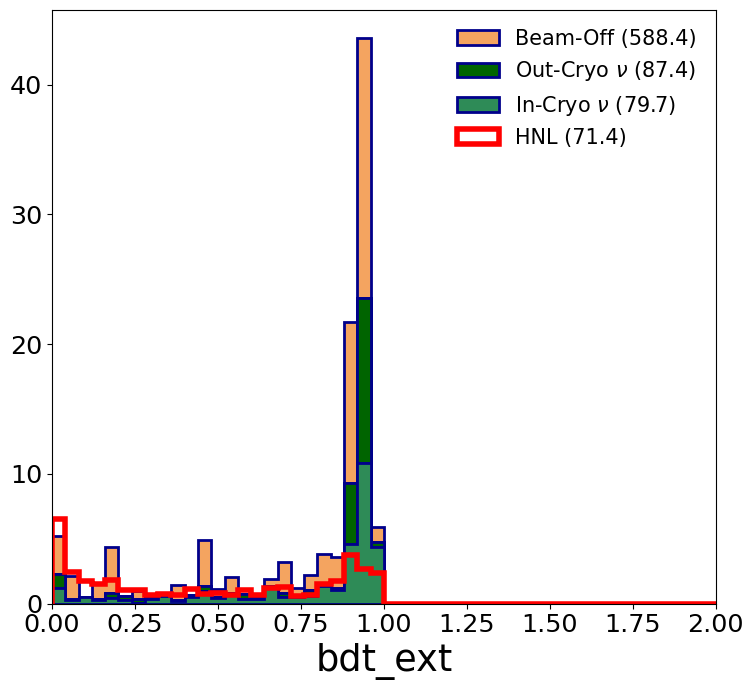

In [37]:
variable = "crtveto"

samples = {"overlay":overlay_from_pkl,
           "dirtoverlay":dirt_from_pkl,
           "beamoff":EXT_from_pkl,
           "signal":signal_samples_dict[HNL_mass]}
samples.update(signal_samples_dict)

if Run == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
           "dirtoverlay":Constants.SF_dirt_run1,
           "beamoff":Constants.SF_EXT_run1,
           "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
elif Run == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
           "dirtoverlay":Constants.SF_dirt_run3,
           "beamoff":Constants.SF_EXT_run3,
           "signal":Constants.run3_POT_scaling_dict[HNL_mass]}

PT.Plot_preselection_variable(variable, samples, sample_norms, xlabel=[],xlims=[0,2],bins=50,figsize=[8,8],HNLplotscale=1000000,logy="False")

In [7]:
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

<class 'pandas.core.series.Series'>
1000
<class 'pandas.core.series.Series'>
1000
<class 'pandas.core.series.Series'>
1000
<class 'pandas.core.series.Series'>
1000


# Pre-selection cuts

In [38]:
#Make cuts on signal
Preselection_dict = {"nslice":"nslice==1",
"flash_time":"flash_time > 5.64 and flash_time < 16.44",
"nu_flashmatch_score":"nu_flashmatch_score < 15",
"NeutrinoEnergy2":"NeutrinoEnergy2 < 500",
"contained_fraction":"contained_fraction > 0.9",
"trk_score":"trk_score < 0.97"
}

#"Containment":""
#"n_track":"n_track < 5"
#"shr_energy_tot":"shr_energy_tot < 1.0"
#"trk_len":"trk_len < 50.0"
#"trk_score":"trk_score < 0.97"

Preselection_efficiency_signal = [1.0]

print(Signal_run1.numentries)
print(len(df_signal_run1))

Preselection_with_list(df_signal_run1, Preselection_dict, Preselection_efficiency_signal)


35281
1000


In [39]:
#Make cuts on bkg
Preselection_efficiency_overlay = [1.0]
Preselection_efficiency_dirt = [1.0]
Preselection_efficiency_EXT = [1.0]

Preselection_with_list(df_overlay_run1, Preselection_dict, Preselection_efficiency_overlay)
Preselection_with_list(df_dirt_run1, Preselection_dict, Preselection_efficiency_dirt)
Preselection_with_list(df_EXT_run1, Preselection_dict, Preselection_efficiency_EXT)

# Plotting

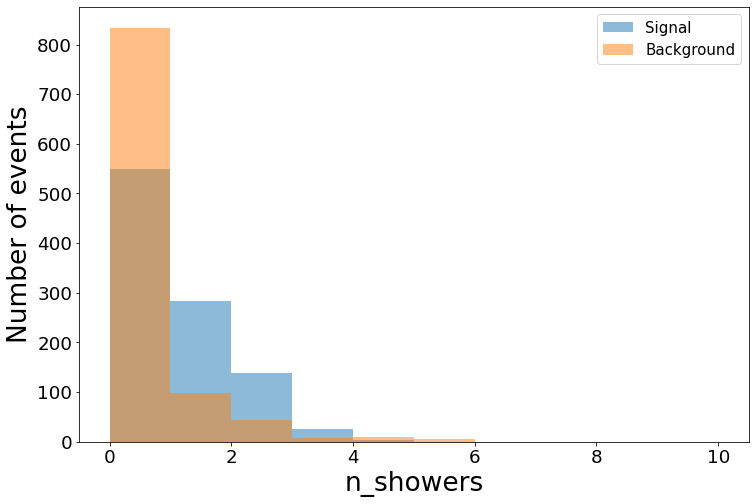

In [44]:
#Single variables
plt.rcParams.update({'font.size': 22})

plot_variable = "n_showers"
range_list=[0,10]

Plot_one_variable(df_signal_run1, df_overlay_run1, plot_variable, 10, range_list, False) #With range
#Plot_one_variable(df_signal_run1, df_NuMI_MC_overlay_pdra_run1, plot_variable, None, loghist=False) #Without range

[1.0, 0.547, 0.542, 0.495, 0.493, 0.366, 0.361]


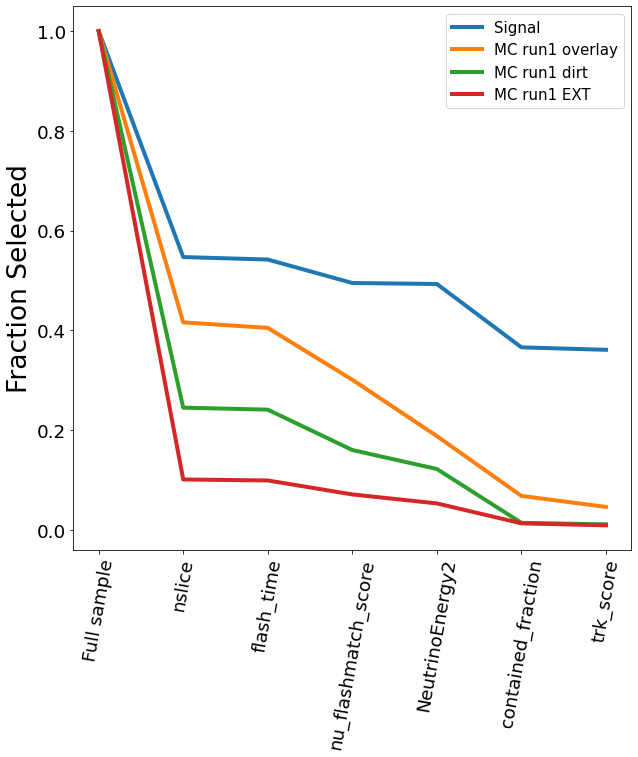

In [45]:
#Plotting efficiency
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_signal,label="Signal",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_overlay,label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_dirt,label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Preselection_efficiency_signal)+1)),Preselection_efficiency_EXT,label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Preselection_efficiency_signal)+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()

print(Preselection_efficiency_signal)

# BDT test and training

In [ ]:
Adityas_variables = [
    'run', # Most crucial
    'sub', # Most crucial
    'evt', # Most crucial
    'shr_energy_tot', # An imp BDT variable for KDAR 2shr and KDAR 1shr in training
    
    # 'shr_phi',
    # 'shr_dedx_Y',
    # 'shr_dedx_Y_cali',
    # 'trkfit',
    # 'shr_score',
    # 'trk_len',
    # 'trk_score',
    # 'total_hits_y',
    # 'shrclusdir0',
    # 'shrclusdir1',
    # 'shr_hits_tot',
    # 'n_tracks_contained',
    # 'n_showers_contained',
    # 'hits_ratio',
    'pfnplanehits_Y', # BDT variable
    'contained_fraction', # BDT variable
    'shr_pitch_u_v', # BDT variable
    'trk_energy', # BDT variable
    'contained_sps_ratio', # BDT variable
    'total_hits_y', # BDT variable
    'trk_energy_hits_tot', # BDT variable
    'shr_start_x', # BDT variable
    'nu_pdg', # Use in plotter
    'ccnc', # Used in plotter
    'nu_parent_pdg', # Will be imp in fixing KL flux
    'theta', # beamdump factor to fix flux for FHC and RHC by 7.7 and 8.6 respectively
    'reco_nu_vtx_sce_x', # Very first cut and used in distance_bw_two_particles()
    'reco_nu_vtx_sce_y', # Very first cut and used in distance_bw_two_particles()
    'reco_nu_vtx_sce_z', # Very first cut and used in distance_bw_two_particles()
    'npi0', # Used in plotter to scale the pi0 by 0.759 factor from BNB
    'crtveto', # Used to veto cosmics in RHC
    # 'pfp_slice_idx',
    # 'category', 
    'slpdg', # BDT variable
    # 'n_showers',
    'trk_score_v', # Most basic cut to separate showers from tracks
    'topological_score', # This might be important later I think
    'weightSplineTimesTune', # To weight each event
    'ppfx_cv', # To weight each Event
    'n_showers_contained_MCStool', # Most basic cut used in selecting 2 shr and 1 shr
    # 'shrPCALen',
    'DeltaMed', # Imp variable for KDAR 2shr 
    'NeutrinoEnergy2', # The most important variable in training the BDT.
    'shr_energy_y_v', # used in defining the leading shr
    'shr_pfp_id_v', # Most basic cut to eliminate inexplicable events in the ntuples
    # 'shr_dist_v', 
    #'bkg_category', # To tag bkg category in def BDT () function
    'hits_v', # BDT variable
    'n_tracks', # BDT variable
    'nu_flashmatch_score', # BDT variable for KDAR 2shr I think
    'pi0_dir1_x', # BDT variable
    'pi0_dir1_z', # BDT variable
    'pi0_energy1_Y', # BDT variable
    'pi0_mass_Y', # BDT variable
    'shrclusdir0', # BDT variable
    'shrclusdir1', # BDT variable
    'shrclusdir2', # BDT variable
    'shr_openangle', # Used in calculating some other variable
    'shr_theta', # BDT variable
    'shr_pca_0', # BDT variable
    'shr_px', # BDT variable
    'shr_px_v', # BDT variable
    'shr_pz', # BDT variable
    'trk_len_v', # An imp variable to use in training the BDT
    'pfnhits', # To select leading shower
    'nslice', # Could be very first cut
    'shr_py_v', # shr_px_v is imp BDT variable but this is for calculating inv_mass
    'shr_pz_v', # Used in calculating inv_mass
    'shr_start_x_v', # Used in calculating distance_bw_two_particles ()
    'shr_start_y_v', # Used in calculating distance_bw_two_particles ()
    'shr_start_z_v', # Used in calculating distance_bw_two_particles ()
    'shr_dedx_y_v' # Used in calculating the energy asymmetry    
    ]